# Glicko-2 Reward Function for Nectar Dataset

This notebook implements a reward function based on Glicko-2 ratings for the Berkeley NEST Nectar dataset. The reward function is defined as:

```
Reward = Glicko-2 Rating - Rating Volatility
```

This rewards items with high ratings while penalizing those with high volatility (inconsistency).

## 1. Installing Required Libraries

In [ ]:
# First, install required packages
!pip install datasets torch numpy matplotlib



## 2. Importing Libraries

In [5]:
# Import libraries
import numpy as np
from datasets import load_dataset
import pandas as pd
from glicko2 import Player
import random
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import time


## 3. Loading the Nectar Dataset from Hugging Face

In [7]:
# This might take some time as it's downloading the dataset
print("Loading dataset...")
start_time = time.time()
dataset = load_dataset("argilla/ultrafeedback-binarized-preferences")
print(f"Dataset loaded in {time.time() - start_time:.2f} seconds")



Loading dataset...
Dataset loaded in 0.54 seconds


In [8]:
# Examine the dataset structure
print("\nDataset structure:")
print(f"Available splits: {dataset.keys()}")
for split in dataset.keys():
    print(f"{split} split: {len(dataset[split])} examples")

# If 'validation' split doesn't exist, we'll use a portion of 'train' for validation

# Display a sample entry
print("\nSample entry:")
sample = dataset['train'][0]
for key, value in sample.items():
    if key in ['chosen', 'rejected']:
        print(f"{key}: {value[:200]}..." if len(value) > 200 else f"{key}: {value}")
    else:
        print(f"{key}: {value}")


Dataset structure:
Available splits: dict_keys(['train'])
train split: 63619 examples

Sample entry:
source: evol_instruct
instruction: Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here's some starter code to help you out:
#include <iostream>
#include <string>
using namespace std;
int main() {
    string country;
    // prompt user for input
    cout << "Enter the name of a country: ";
    cin >> country;
    // check if country borders the Mediterranean Sea
    // [C++ code]
    return 0;
}
chosen_response: Here's a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea:

#include <iostream>
#include <string>
#include <set>
#include <map>
#include <algorithm>

using namespace std;

int main() {
    // store countries and their bordering seas in a map
    map<string, set<string>> countries;
    countries["Algeria"] = {"Mediterranean Sea", "North 

In [19]:
## Preprocess the Dataset

def preprocess_dataset(dataset, split='train', sample_size=None):
    """
    Preprocess the dataset to extract chosen and rejected responses.
    
    Args:
        dataset: The loaded dataset
        split: The dataset split to use ('train' or 'validation')
        sample_size: Optional number of examples to sample (for faster development)
        
    Returns:
        chosen_responses, rejected_responses: Lists of preprocessed responses
    """
    data = dataset[split]
    
    # If sample_size is provided and smaller than the data size, take a random sample
    if sample_size and sample_size < len(data):
        indices = random.sample(range(len(data)), sample_size)
        data = [data[i] for i in indices]
    else:
        data = list(data)
    
    chosen_responses = []
    rejected_responses = []
    
    for item in data:
        chosen = item['chosen_response']
        rejected = item['rejected_response']
        prompt = item['source']
        
        chosen_responses.append({
            'response': chosen,
            'prompt': prompt,
            'status': 'chosen'
        })
        
        rejected_responses.append({
            'response': rejected,
            'prompt': prompt,
            'status': 'rejected'
        })
    
    return chosen_responses, rejected_responses



## Initialize Glicko-2 Players

def initialize_glicko2_players(chosen_responses, rejected_responses):
    """
    Initialize Glicko-2 players for all unique responses.
    """
    # Create a unique identifier for each response
    all_responses = chosen_responses + rejected_responses
    response_to_id = {}
    
    for i, response_data in enumerate(all_responses):
        response = response_data['response']
        if response not in response_to_id:
            response_to_id[response] = f"response_{len(response_to_id)}"
    
    # Initialize Glicko-2 players with default rating=1500, rd=350, vol=0.06
    players = {}
    for response, response_id in response_to_id.items():
        players[response_id] = Player()
    
    print(f"Initialized {len(players)} unique Glicko-2 players")
    return players, response_to_id
def simulate_matches(chosen_responses, rejected_responses, players, response_to_id, num_epochs=5):
    """
    Simulate matches between chosen and rejected responses to update Glicko-2 ratings.
    """
    # Group responses by prompt
    prompt_to_responses = defaultdict(list)
    
    for response_data in chosen_responses + rejected_responses:
        prompt = response_data['prompt']
        response = response_data['response']
        status = response_data['status']
        
        prompt_to_responses[prompt].append({
            'response': response,
            'status': status,
            'id': response_to_id[response]
        })
    
    print(f"Grouped responses by {len(prompt_to_responses)} unique prompts")
    
    # Records for plotting
    epochs = []
    avg_chosen_ratings = []
    avg_rejected_ratings = []
    avg_chosen_rds = []
    avg_rejected_rds = []
    
    # Simulate matches for multiple epochs
    for epoch in tqdm(range(num_epochs), desc="Training epochs"):
        # Shuffle prompts for randomization
        prompts = list(prompt_to_responses.keys())
        random.shuffle(prompts)
        
        match_count = 0
        for prompt in prompts:
            responses = prompt_to_responses[prompt]
            
            # Find chosen and rejected responses for this prompt
            chosen = [r for r in responses if r['status'] == 'chosen']
            rejected = [r for r in responses if r['status'] == 'rejected']
            
            # For each chosen-rejected pair, simulate a match where chosen wins
            for c in chosen:
                for r in rejected:
                    # The chosen response wins against the rejected response
                    c_player = players[c['id']]
                    r_player = players[r['id']]
                    
                    # Update immediately (not batch update)
                    c_player.update_player([r_player.rating], [r_player.rd], [1])
                    r_player.update_player([c_player.rating], [c_player.rd], [0])
                    match_count += 1
        
        print(f"Epoch {epoch+1}: Simulated {match_count} matches")
        
        # Record statistics for plotting
        chosen_ratings = [players[response_to_id[r['response']]].rating for r in chosen_responses]
        rejected_ratings = [players[response_to_id[r['response']]].rating for r in rejected_responses]
        chosen_rds = [players[response_to_id[r['response']]].rd for r in chosen_responses]
        rejected_rds = [players[response_to_id[r['response']]].rd for r in rejected_responses]
        
        epochs.append(epoch + 1)
        avg_chosen_ratings.append(np.mean(chosen_ratings))
        avg_rejected_ratings.append(np.mean(rejected_ratings))
        avg_chosen_rds.append(np.mean(chosen_rds))
        avg_rejected_rds.append(np.mean(rejected_rds))
    
    # Plot the training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot average ratings
    ax1.plot(epochs, avg_chosen_ratings, 'g-', label='Chosen Responses')
    ax1.plot(epochs, avg_rejected_ratings, 'r-', label='Rejected Responses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Average Rating')
    ax1.set_title('Average Ratings During Training')
    ax1.legend()
    ax1.grid(True)
    
    # Plot average rating deviations
    ax2.plot(epochs, avg_chosen_rds, 'g--', label='Chosen Responses')
    ax2.plot(epochs, avg_rejected_rds, 'r--', label='Rejected Responses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Average Rating Deviation')
    ax2.set_title('Average Rating Deviations During Training')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return players

In [18]:

# For faster development, let's use a smaller sample size initially
# Set sample_size=None to use the full dataset
sample_size = 5000  # Adjust this as needed
print(f"\nPreprocessing dataset with sample_size={sample_size}...")
start_time = time.time()
chosen_responses, rejected_responses = preprocess_dataset(dataset, 'train', sample_size)
print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")
print(f"Processed {len(chosen_responses)} chosen and {len(rejected_responses)} rejected responses")


print("\nInitializing Glicko-2 players...")
start_time = time.time()
players, response_to_id = initialize_glicko2_players(chosen_responses, rejected_responses)
print(f"Initialization completed in {time.time() - start_time:.2f} seconds")


Preprocessing dataset with sample_size=5000...
Preprocessing completed in 0.30 seconds
Processed 5000 chosen and 5000 rejected responses

Initializing Glicko-2 players...
Initialized 9864 unique Glicko-2 players
Initialization completed in 0.14 seconds


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'instruction', 'chosen_response', 'rejected_response', 'chosen_avg_rating', 'rejected_avg_rating', 'chosen_model'],
        num_rows: 63619
    })
})


Simulating matches...
Grouped responses by 9 unique prompts


Training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Simulated 5152764 matches
Epoch 2: Simulated 5152764 matches
Epoch 3: Simulated 5152764 matches
Epoch 4: Simulated 5152764 matches
Epoch 5: Simulated 5152764 matches


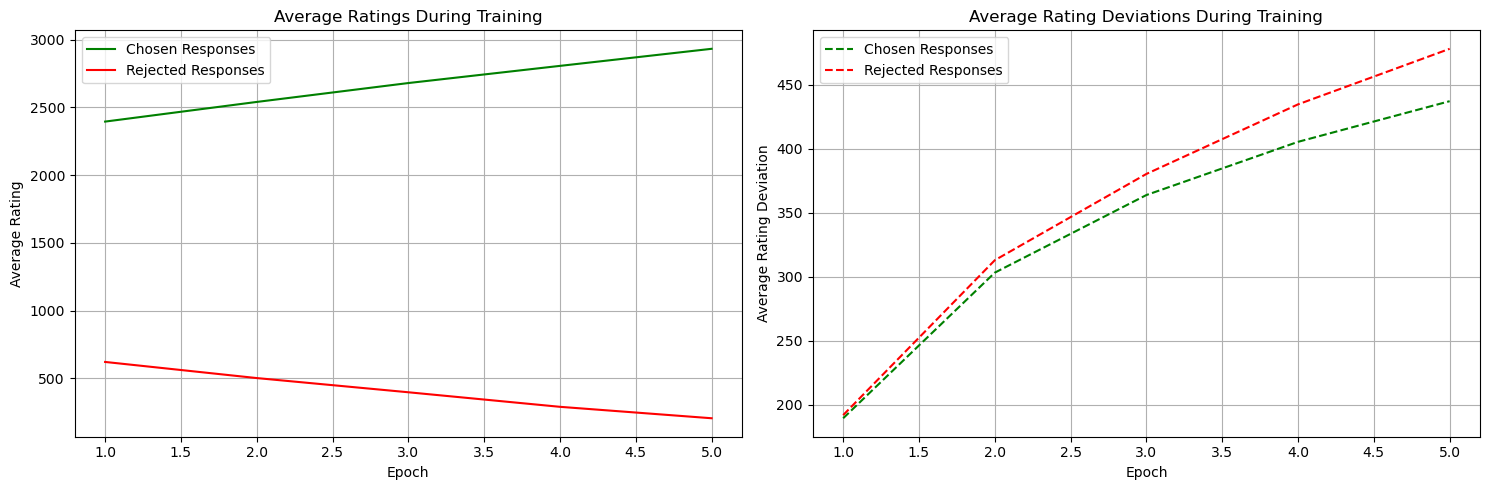

Match simulation completed in 363.89 seconds


In [20]:
print("\nSimulating matches...")
start_time = time.time()
num_epochs = 5  # Adjust as needed
players = simulate_matches(chosen_responses, rejected_responses, players, 
                           response_to_id, num_epochs=num_epochs)
print(f"Match simulation completed in {time.time() - start_time:.2f} seconds")

In [26]:
def evaluate_model(players, response_to_id, alpha, dataset, sample_size=None, validation_split='test'):
    """
    Evaluate the reward model on the validation set.
    
    Args:
        players: Dictionary of Glicko-2 players
        response_to_id: Mapping from response to player ID
        alpha: Hyperparameter controlling the penalty for uncertainty
        dataset: The loaded dataset
        sample_size: Optional number of examples to sample
        validation_split: The split to use for validation (default: 'test')
    """
    # Check available splits and use an appropriate one for validation
    if validation_split not in dataset:
        print(f"Warning: '{validation_split}' split not found. Available splits: {dataset.keys()}")
        validation_split = list(dataset.keys())[0]  # Use the first available split
        print(f"Using '{validation_split}' split for evaluation instead")
    
    # Process validation data
    chosen_responses_val, rejected_responses_val = preprocess_dataset(
        dataset, validation_split, sample_size)
    
    # Calculate rewards for chosen and rejected responses
    chosen_rewards = []
    rejected_rewards = []
    
    for chosen, rejected in zip(chosen_responses_val, rejected_responses_val):
        chosen_reward = calculate_reward_function(chosen['response'], players, response_to_id, alpha)
        rejected_reward = calculate_reward_function(rejected['response'], players, response_to_id, alpha)
        
        chosen_rewards.append(chosen_reward)
        rejected_rewards.append(rejected_reward)
    
    # Calculate accuracy: percentage of pairs where chosen reward > rejected reward
    correct_pairs = sum(1 for c, r in zip(chosen_rewards, rejected_rewards) if c > r)
    total_pairs = len(chosen_rewards)
    
    accuracy = correct_pairs / total_pairs if total_pairs > 0 else 0
    
    print(f"Evaluation on {total_pairs} validation pairs:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Chosen responses average reward: {np.mean(chosen_rewards):.2f}")
    print(f"Rejected responses average reward: {np.mean(rejected_rewards):.2f}")
    
    # Plot the reward distributions
    plt.figure(figsize=(10, 6))
    
    plt.hist(chosen_rewards, alpha=0.5, bins=30, label='Chosen Responses', color='green')
    plt.hist(rejected_rewards, alpha=0.5, bins=30, label='Rejected Responses', color='red')
    
    plt.title(f'Reward Distribution (alpha={alpha})')
    plt.xlabel('Reward Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return accuracy, chosen_rewards, rejected_rewards
def calculate_reward_function(response, players, response_to_id, alpha=0.5):
    """
    Calculate the reward function: rating - (alpha * rating_deviation)
    
    Args:
        response: The text response to evaluate
        players: Dictionary of Glicko-2 players
        response_to_id: Mapping from response to player ID
        alpha: Hyperparameter controlling the penalty for uncertainty
        
    Returns:
        float: The reward score
    """
    if response in response_to_id:
        player_id = response_to_id[response]
        player = players[player_id]
        
        # Calculate reward: rating - (alpha * rating_deviation)
        reward = player.rating - (alpha * player.rd)
        return reward
    else:
        # For unseen responses, we return a default score
        # This can be adjusted based on how new responses should be treated
        default_player = Player()  # Default rating=1500, rd=350
        return default_player.rating - (alpha * default_player.rd)


Using 'train' split for evaluation

Evaluating model with alpha=0.1
Evaluation on 1000 validation pairs:
Accuracy: 0.1050
Chosen responses average reward: 1600.40
Rejected responses average reward: 1339.99


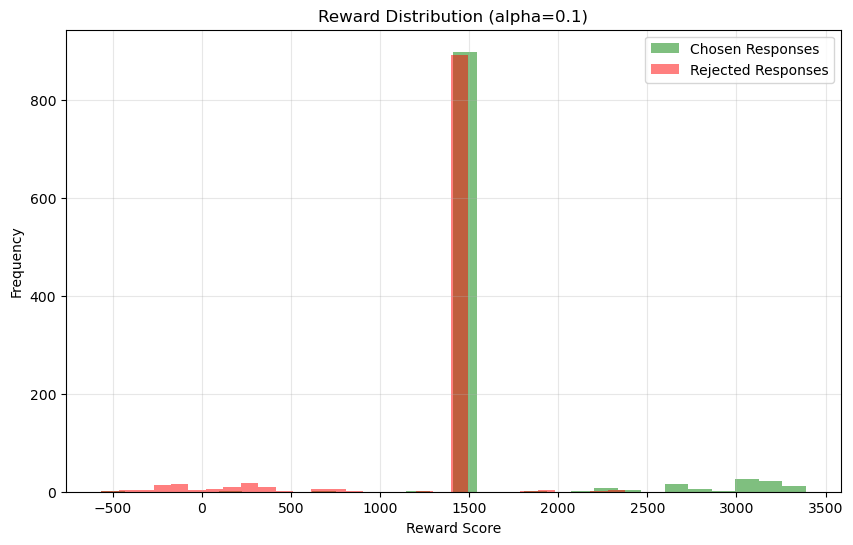


Evaluating model with alpha=0.5
Evaluation on 1000 validation pairs:
Accuracy: 0.0980
Chosen responses average reward: 1439.29
Rejected responses average reward: 1208.38


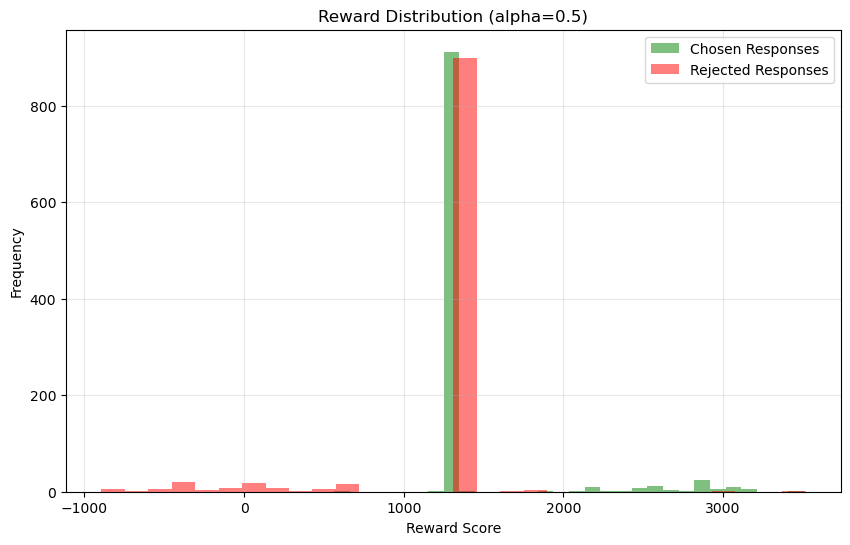


Evaluating model with alpha=1.0
Evaluation on 1000 validation pairs:
Accuracy: 0.0790
Chosen responses average reward: 1244.76
Rejected responses average reward: 1052.08


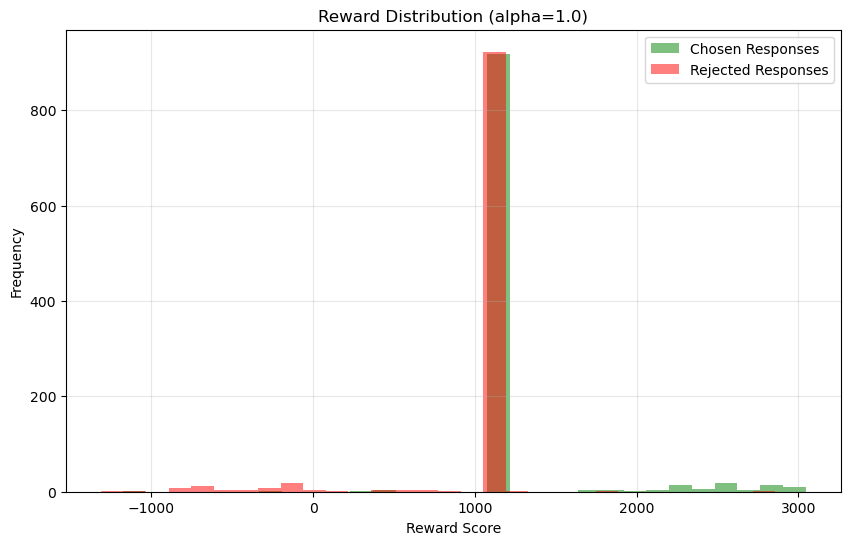

In [27]:
alphas = [0.1, 0.5, 1.0]
results = {}

# Determine which split to use for evaluation
validation_split = 'test' if 'test' in dataset else 'train'
print(f"\nUsing '{validation_split}' split for evaluation")

for alpha in alphas:
    print(f"\nEvaluating model with alpha={alpha}")
    val_sample_size = 1000  # Adjust as needed
    accuracy, chosen_rewards, rejected_rewards = evaluate_model(
        players, response_to_id, alpha, dataset, val_sample_size, validation_split)
    
    results[alpha] = {
        'accuracy': accuracy,
        'avg_chosen_reward': np.mean(chosen_rewards),
        'avg_rejected_reward': np.mean(rejected_rewards),
        'reward_diff': np.mean(chosen_rewards) - np.mean(rejected_rewards)
    }


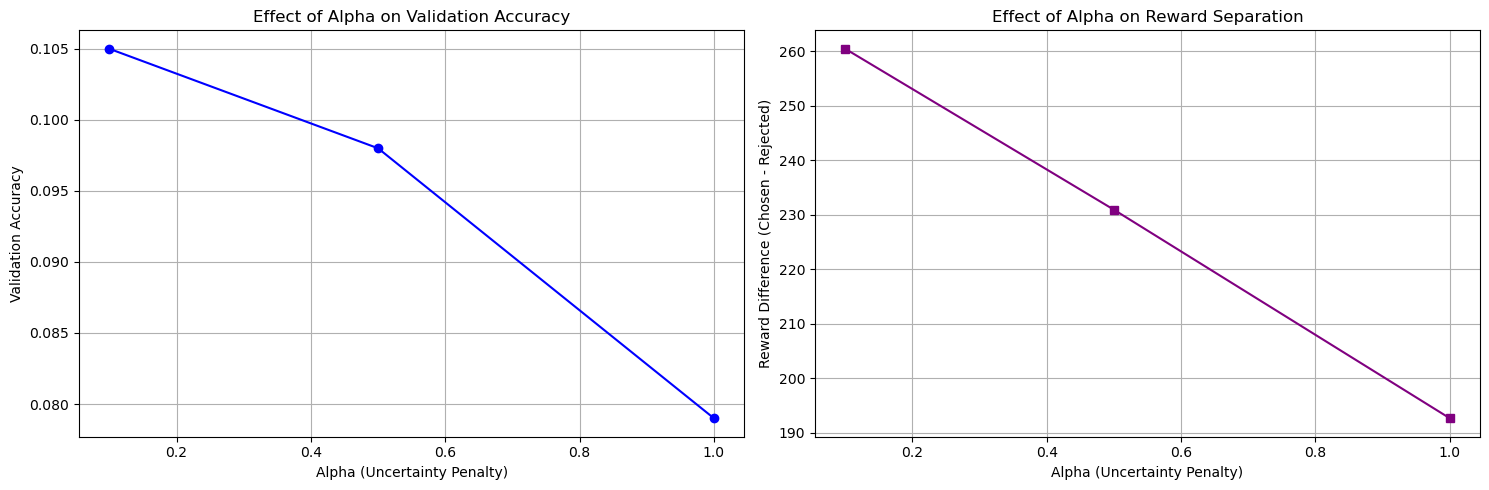

In [30]:
# Plot accuracy vs alpha
alphas_list = list(results.keys())
accuracies = [results[a]['accuracy'] for a in alphas_list]
reward_diffs = [results[a]['reward_diff'] for a in alphas_list]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(alphas_list, accuracies, 'o-', color='blue')
ax1.set_xlabel('Alpha (Uncertainty Penalty)')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Effect of Alpha on Validation Accuracy')
ax1.grid(True)

ax2.plot(alphas_list, reward_diffs, 's-', color='purple')
ax2.set_xlabel('Alpha (Uncertainty Penalty)')
ax2.set_ylabel('Reward Difference (Chosen - Rejected)')
ax2.set_title('Effect of Alpha on Reward Separation')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Find the best alpha based on accuracy
best_alpha = max(results.keys(), key=lambda a: results[a]['accuracy'])
print(f"\nBest alpha value: {best_alpha}")
print(f"Validation accuracy with best alpha: {results[best_alpha]['accuracy']:.4f}")


Best alpha value: 0.1
Validation accuracy with best alpha: 0.1050


In [33]:
# Save the model components for later use
model_data = {
    'players': players,
    'response_to_id': response_to_id,
    'best_alpha': best_alpha,
    'results': results
}

with open('glicko2_reward_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\nModel saved to 'glicko2_reward_model.pkl'")



Model saved to 'glicko2_reward_model.pkl'


In [35]:
# Define a function to score new responses
def reward_function(response, alpha=best_alpha):
    return calculate_reward_function(response, players, response_to_id, alpha)

# Example responses to score
example_responses = [
    "This is a high-quality, detailed response that thoroughly addresses all aspects of the user's question with accurate information and helpful context.",
    "I don't know the answer to that.",
    "The question is about physics, which involves the study of matter and energy.",
    sample['chosen_response'],  # A chosen response from the dataset
    sample['rejected_response']  # A rejected response from the dataset
]



In [38]:
# Score the example responses
print("\nScoring example responses:")
for i, response in enumerate(example_responses):
    score = reward_function(response)
    print(f"Example {i+1} score: {score:.2f}")
    print(f"Response preview: {response[:100]}..." if len(response) > 100 else f"Response: {response}")
    print()

## Conclusion
print("\nSummary:")
print(f"- Trained on {len(chosen_responses)} chosen and {len(rejected_responses)} rejected responses")
print(f"- Best alpha value: {best_alpha}")
print(f"- Validation accuracy: {results[best_alpha]['accuracy']:.4f}")
print(f"- Average reward difference: {results[best_alpha]['reward_diff']:.2f}")
print("\nThe reward function is ready to use for RLHF!")


Scoring example responses:
Example 1 score: 1465.00
Response preview: This is a high-quality, detailed response that thoroughly addresses all aspects of the user's questi...

Example 2 score: 1465.00
Response: I don't know the answer to that.

Example 3 score: 1465.00
Response: The question is about physics, which involves the study of matter and energy.

Example 4 score: 1465.00
Response preview: Here's a C++ program that prompts the user to enter the name of a country and checks if it borders t...

Example 5 score: 1465.00
Response preview: Sure, here is the program using the C++11 algorithm "cds::algorithm::GreaterEqual":
#include <iostre...


Summary:
- Trained on 5000 chosen and 5000 rejected responses
- Best alpha value: 0.1
- Validation accuracy: 0.1050
- Average reward difference: 260.41

The reward function is ready to use for RLHF!
